# Predicting Swiggy Restaurant Delivery Times: A Machine Learning Analysis

## Research Question

To what extent can features of Swiggy restaurant profiles (e.g., location, food type, average ratings, price, total ratings) be used to build regression models to predict delivery times, and which features are most significant after applying feature selection techniques?

## 1. Overview & Setup

In this analysis, we'll explore a dataset of Swiggy restaurants to build predictive models for delivery times. We'll:

- Import the required libraries for data analysis and modeling
- Load and clean the Swiggy restaurant dataset
- Perform exploratory data analysis 
- Build and evaluate multiple regression models
- Identify key factors influencing delivery times
- Apply model reduction techniques to improve efficiency

Let's begin by setting up our environment and importing the necessary libraries.

In [2]:
# Import essential libraries for data analysis and machine learning
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, lasso_path
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import math
import warnings
import os
import re

# Create output directory for saving visualizations
output_dir = "./output_plots"
os.makedirs(output_dir, exist_ok=True)

# Attempt to import XGBoost; if not available, skip XGBoost model.
try:
    from xgboost import XGBRegressor
    xgboost_available = True
    print("XGBoost library found.")
except ImportError:
    XGBRegressor = None
    xgboost_available = False
    print("XGBoost library not found. XGBoost model will be skipped.")

# Suppress warnings for cleaner output.
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set visualization style.
try:
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_context("notebook", font_scale=1.1)
except Exception:
    print("Seaborn style not found, using default.")

XGBoost library found.


We've set up our environment with essential libraries for data analysis, machine learning, and visualization. The code includes error handling for optional packages like XGBoost, ensuring the analysis can run even if certain libraries aren't available. We'll use a consistent visualization style throughout the analysis for coherent presentation of results.

## 2. Data Acquisition and Initial Storage

In this section, we'll load the Swiggy dataset from a CSV file and store it in a SQLite database for easier access and manipulation. We will observe raw data to understand its structure before proceeding with cleaning and analysis. We use a try-except nested loop to handle encoding issues while loading CSV.

In [3]:
# Define file paths and database configuration
csv_file = r"C:\Users\eanur\Downloads\swiggy (2).csv"  # Loading our CSV file
db_name = "swiggy_presentation_script.db"  # SQLite database name
table_name_raw = "restaurants_raw" # Table name for raw CSV data to be stored in database
try:
    # Attempt to load CSV with different encodings if needed
    try:
        df = pd.read_csv(csv_file)
    except UnicodeDecodeError:
        print("Default encoding failed, trying latin1...")
        try:
            df = pd.read_csv(csv_file, encoding="latin1")
        except UnicodeDecodeError:
            print("latin1 encoding failed, trying utf-8-sig...")
            df = pd.read_csv(csv_file, encoding="utf-8-sig")

    # Validate successful loading
    if df is None or df.empty:
        raise ValueError("Dataset loading failed or resulted in an empty DataFrame.") # we are making sure if raw data is loaded correctly into the database
     # If dataset is loaded correctly then let's print the shape of the dataset and the first 3 rows of the dataset.
    print("Dataset loaded successfully.")
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print("\nInitial 3 rows:")
    print(df.head(3))
    print("\nColumn names as loaded:", df.columns.tolist())

    # Connect to SQLite database and store raw data.
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name_raw, conn, if_exists="replace", index=False) # Store raw data in SQLite DB into a table named 'restaurants_raw' and if the table already exists because of previous executions , it will be replaced.
    print(f"Raw data stored in SQLite DB: '{db_name}', Table: '{table_name_raw}'")

    # Verify storage.
    query = f"SELECT COUNT(*) FROM {table_name_raw}"
    row_count = pd.read_sql_query(query, conn).iloc[0, 0]  #counts number of rows in the table
    print(f"Verified DB storage: {row_count} records in '{table_name_raw}'")
except Exception as e: # Outer try-except block to catch any errors during the data acquisition process and closes the connection.
    print(f"Error during data acquisition: {e}")
    if 'conn' in locals():
        conn.close()
    raise e

Dataset loaded successfully.
Dataset loaded: 8680 rows, 10 columns

Initial 3 rows:
    ID         Area       City     Restaurant  Price  Avg ratings  \
0  211  Koramangala  Bangalore    Tandoor Hut  300.0          4.4   
1  221  Koramangala  Bangalore  Tunday Kababi  300.0          4.1   
2  246    Jogupalya  Bangalore        Kim Lee  650.0          4.4   

   Total ratings                                  Food type      Address  \
0            100  Biryani,Chinese,North Indian,South Indian    5Th Block   
1            100                           Mughlai,Lucknowi    5Th Block   
2            100                                    Chinese  Double Road   

   Delivery time  
0             59  
1             56  
2             50  

Column names as loaded: ['ID', 'Area', 'City', 'Restaurant', 'Price', 'Avg ratings', 'Total ratings', 'Food type', 'Address', 'Delivery time']
Raw data stored in SQLite DB: 'swiggy_presentation_script.db', Table: 'restaurants_raw'
Verified DB storage: 8680 

### Data Acquisition Insights

The Swiggy restaurant dataset has been successfully loaded and stored in a SQLite database. This approach offers several advantages:

1. **Persistence**: The data is now stored in a database file that can be accessed across sessions without reloading the original CSV
2. **Query Capability**: SQL queries can be used for complex data extraction if needed later
3. **Data Integrity**: The database ensures data consistency throughout the analysis
4. **Scalability**: If the dataset grows, the SQLite database can handle larger volumes of data more efficiently than in-memory structures

The code includes robust error handling to address common issues like encoding problems when loading CSV files. We verified that all 8,680 records were successfully stored in the database, providing a solid foundation for our analysis.

## 3. Data Cleaning and Preparation

Before building our predictive models, we need to clean the data to prepare it for analysis. This includes:

- Examining data types and missing values
- Cleaning and transforming variables
- Handling missing values appropriately

In [4]:
# 3.1 Initial Data Structure Overview
print("\n3.1 Initial Data Overview")
df.info() # display the data types of the columns and the number of non-null values in each column
print("\nNumerical Summary:")
print(df.describe(include=np.number).T) # to calculate the summary statistics of the numerical columns in the dataset like mean,median,min, max, std, etc.
print("\nCategorical Summary:")
print(df.describe(include="object").T)
print("\nMissing Values (%):") # to calculate the percentage of missing values
print((df.isnull().sum()/len(df)*100).sort_values(ascending=False)) # to calculate the percentage of missing values in each column and sort them in descending order.

# 3.2 Column Definition & Cleaning
print("\n3.2 Column Definition & Cleaning")
# Print the columns found in the DataFrame
print(f"\n*** COLUMNS FOUND: {df.columns.tolist()} ***\n")

# Define important column names for analysis
rating_col       = "Avg ratings"       # Restaurant's average rating
cost_col         = "Price"             # Average price of menu items
time_col         = "Delivery time"     # Target variable: delivery time in minutes
city_col         = "City"              # Location of the restaurant
cuisine_col      = "Food type"         # Types of cuisine offered
rating_count_col = "Total ratings"     # Number of customer ratings
target_variable  = time_col            # Our prediction target: delivery time

print(f"Target variable set to: '{target_variable}'") # We are defining a new variable and assign a value to it for our analysis to make our predictions

# Clean each column based on its expected type
for col_name, col_type in [(rating_col, "rating"), (cost_col, "cost"),
                           (time_col, "time"), (rating_count_col, "count"),
                           (city_col, "categorical"), (cuisine_col, "categorical")]:
    if col_name in df.columns:
        print(f"Cleaning column: '{col_name}' (type: {col_type})")
        try:
            # For numeric-type columns, convert to string then extract numeric values
            if col_type in ["rating", "cost", "time", "count"]:
                df[col_name] = df[col_name].astype(str)
                if col_type == "rating": #converting the rating column to numeric values
                    df[col_name] = df[col_name].replace(["--", "NEW", "-", "Opening Soon", "Temporarily Closed", "nan", "None"], np.nan)
                df[col_name] = df[col_name].str.extract(r"(\d+(?:\.\d+)?)", expand=False) # Extract numeric values from strings if conversion fails those values are taken asNan.
                df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
                missing_count = df[col_name].isnull().sum() # Count missing values after conversion
                # Fill missing values with median for count-type or mean for other numeric types, for missing values take it as 0
                fill_value = df[col_name].median() if col_type=="count" else df[col_name].mean()
                if pd.isna(fill_value):
                    fill_value = 0
                df[col_name].fillna(fill_value, inplace=True)
                print(f"  Filled {missing_count} NaNs with {'median' if col_type=='count' else 'mean'} ({fill_value:.2f})")
            elif col_type == "categorical":
                missing_count = df[col_name].isnull().sum()
                df[col_name] = df[col_name].astype(str).fillna("Unknown") # Convert to string and fill NaNs with "Unknown" in categorical columns
                if missing_count > 0:
                    print(f"  Filled {missing_count} NaNs with 'Unknown'")
        except Exception as e:
            print(f"  Error cleaning {col_name}: {e}")
            if col_name == target_variable:
                print(f"FATAL: Cannot clean target variable '{target_variable}'. Exiting.")
                raise e
    else:
        print(f"Column '{col_name}' not found in DataFrame, skipping cleaning.")

# Final check for target variable cleaning
if target_variable in df.columns:
    if not pd.api.types.is_numeric_dtype(df[target_variable]):
        print(f"ERROR: Target variable '{target_variable}' is not numeric after cleaning. Exiting.")
        raise TypeError(f"Target variable '{target_variable}' must be numeric")
    if df[target_variable].isnull().any():
        initial_rows = len(df)
        df.dropna(subset=[target_variable], inplace=True) # Drop rows with NaN in target variable
        print(f"Dropped {initial_rows - len(df)} rows with missing target '{target_variable}'")
    if df.empty: # Check if DataFrame is empty after cleaning
        print(f"ERROR: DataFrame empty after cleaning target variable '{target_variable}'. Exiting.")
        raise ValueError("No data remaining after cleaning")
else:
    print(f"ERROR: Target variable '{target_variable}' not found in DataFrame. Exiting.")
    raise KeyError(f"Target variable '{target_variable}' not found in dataset")


3.1 Initial Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             8680 non-null   int64  
 1   Area           8680 non-null   object 
 2   City           8680 non-null   object 
 3   Restaurant     8680 non-null   object 
 4   Price          8680 non-null   float64
 5   Avg ratings    8680 non-null   float64
 6   Total ratings  8680 non-null   int64  
 7   Food type      8680 non-null   object 
 8   Address        8680 non-null   object 
 9   Delivery time  8680 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 678.3+ KB

Numerical Summary:
                count           mean            std    min      25%       50%  \
ID             8680.0  244812.071429  158671.617188  211.0  72664.0  283442.0   
Price          8680.0     348.444470     230.940074    0.0    200.0     300.0   
Avg ratings

### Data Cleaning Insights

Our data cleaning process revealed important characteristics of the Swiggy dataset:

1. **Data Quality**: We identified and addressed several quality issues including non-numeric values in numeric fields (e.g., "NEW" or "--" in ratings columns) and missing values. These issues could have significantly impacted model performance if left unaddressed.

2. **Variable Types**: The dataset contains a mix of numeric features (ratings, price, total ratings) and categorical features (city, food type). Each required different cleaning approaches - numeric fields were converted and verified, while categorical fields were standardized.

3. **Missing Values Strategy**: For numeric columns, we filled missing values with means or medians depending on the distribution characteristics. For categorical features, we used the label "Unknown". This approach preserves data volume while minimizing bias.

4. **Target Variable Integrity**: We ensured that our target variable (Delivery time) is completely non-null and numeric, which is critical for supervised learning. If any rows had missing target values, they were removed to prevent training issues.

The cleaning steps were thorough and systematic, handling each column based on its intended use and data type. This careful preparation ensures that our analysis is based on valid, consistent data, reducing the risk of spurious results or model failures later in the process.

## 4. Feature Engineering and Selection

Now that our data is clean, we'll create new features that might help with prediction and select the most relevant variables for our models.
We create two specialized pipelines—one for numerical features (using StandardScaler to normalize the data) and one for categorical features (using OneHotEncoder to convert text categories into binary columns). These pipelines are then combined into a single ColumnTransformer that applies the appropriate transformations to our selected features while discarding irrelevant ones. Finally, we split the dataset into training and testing sets, apply the preprocessor to both, and retrieve the processed feature names for further analysis.


In [5]:
# 4.1 Feature Engineering: Create 'Cuisine_Count'
print("\n4.1 Feature Engineering")
if cuisine_col in df.columns:
    df[cuisine_col].fillna("Unknown", inplace=True)
    try:
        # Count number of cuisines offered by each restaurant (using comma separator in string)
        df["Cuisine_Count"] = df[cuisine_col].str.split(",").apply(len)
        print("Engineered feature 'Cuisine_Count' from 'Food type'.")
    except Exception as e:
        print(f"Error engineering 'Cuisine_Count': {e}")
        df["Cuisine_Count"] = 1

# 4.2 Feature Selection for Modeling
print("\n4.2 Feature Selection for Modeling")
# Identify numerical and categorical columns after cleaning
num_after_clean = df.select_dtypes(include=np.number).columns.tolist()
cat_after_clean = df.select_dtypes(include=["object"]).columns.tolist()
if target_variable in num_after_clean: # Remove target variable from numerical features
    num_after_clean.remove(target_variable)

# Select features for modeling
selected_numerical = [col for col in [rating_col, cost_col, rating_count_col, "Cuisine_Count"] 
                      if col in df.columns and col in num_after_clean] 
selected_categorical = [col for col in [city_col] 
                        if col in df.columns and col in cat_after_clean]

final_feature_columns = selected_numerical + selected_categorical # Combine selected numerical and categorical features for analysis
print(f"Selected Numerical Features: {selected_numerical}")
print(f"Selected Categorical Features: {selected_categorical}")
print(f"Total features selected: {len(final_feature_columns)}")

if len(final_feature_columns) < 2: # Check if we have at least 2 independent features for modeling
    print("Error: Need at least 2 independent features.")
    raise ValueError("Insufficient features for modeling")

# Define X (features) and y (target)
X = df[final_feature_columns].copy()
y = df[target_variable].copy()
print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")

# Check for dataset size requirement
if len(df) < 200:
    print(f"Error: Dataset contains {len(df)} records; minimum 200 are required.")
    raise ValueError("Dataset too small for reliable modeling")

# 4.3 Preprocessing Pipeline Setup
print("\n4.3 Preprocessing Pipeline Setup")
# Create preprocessing pipelines for numerical and categorical features and standardize numerical features taking mean as 0 and std as 1
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]) # OneHotEncoder is used to convert categorical variables into binary variables.

# Combine numerical and categorical transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        # num and cat transformers apply StandardScaler and OneHotEncoder respectively to the selected numerical and categorical features.
        ("num", numeric_transformer, selected_numerical), 
        ("cat", categorical_transformer, selected_categorical)
    ],
    remainder="drop", #Any unnecessary columns will be dropped
    verbose_feature_names_out=False
)
preprocessor.set_output(transform="pandas") # Setting our output data column to be pandas dataframe

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")

# Apply preprocessing transformations
try:
    X_train_processed = preprocessor.fit_transform(X_train) # Fit the preprocessor on training data and transform it
    X_test_processed = preprocessor.transform(X_test) # Transform the test data using the fitted preprocessor
    
    # Retrieve feature names after preprocessing
    if hasattr(preprocessor, "get_feature_names_out"):
        processed_feature_names = preprocessor.get_feature_names_out()
    else:
        # Fallback for older scikit-learn versions
        processed_feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if name != "remainder":
                if hasattr(transformer, "get_feature_names_out"):
                    feat = transformer.get_feature_names_out(features)
                elif hasattr(transformer, "get_feature_names"):
                    feat = transformer.get_feature_names(features)
                else:
                    feat = features
                processed_feature_names.extend(feat)
    print(f"Preprocessing complete. Processed features count: {len(processed_feature_names)}")
    print(f"First 5 processed feature names: {processed_feature_names[:5]}")
except Exception as e:
    print(f"Error during preprocessing: {e}")
    raise e


4.1 Feature Engineering
Engineered feature 'Cuisine_Count' from 'Food type'.

4.2 Feature Selection for Modeling
Selected Numerical Features: ['Avg ratings', 'Price', 'Total ratings', 'Cuisine_Count']
Selected Categorical Features: ['City']
Total features selected: 5
Features (X) shape: (8680, 5), Target (y) shape: (8680,)

4.3 Preprocessing Pipeline Setup
Train set: 6944 samples, Test set: 1736 samples
Preprocessing complete. Processed features count: 13
First 5 processed feature names: ['Avg ratings' 'Price' 'Total ratings' 'Cuisine_Count' 'City_Ahmedabad']


### Feature Engineering and Selection Insights

Our feature engineering and selection process yielded several valuable insights:

1. **Cuisine Diversity**: We created a new feature called "Cuisine_Count" that measures the number of cuisine types offered by each restaurant. This engineered feature captures menu diversity, which could influence preparation complexity and thus delivery times. Restaurants with more cuisine types might have longer preparation times due to kitchen complexity.

2. **Feature Selection**: From the available variables, we selected five key features for modeling:
   - **Average Ratings**: Higher-rated restaurants may have different service standards affecting delivery time
   - **Price**: Premium restaurants might prioritize quality over speed
   - **Total Ratings**: More popular restaurants might have higher order volumes impacting delivery efficiency
   - **Cuisine Count**: Our engineered feature capturing menu complexity
   - **City**: Location is likely a major factor affecting delivery logistics and traffic conditions

3. **Data Preprocessing**: We implemented a preprocessing pipeline with:
   - Standardization for numerical features (ensuring all features have similar scale)
   - One-hot encoding for categorical features (converting city names to binary features)
   
4. **Training/Testing Split**: We divided the data using an 80/20 split with 6,944 training samples and 1,736 testing samples. This split provides ample training data while retaining a substantial test set for reliable performance evaluation.

5. **Processed Feature Space**: After preprocessing, our feature space expanded from 5 raw features to 13 processed features (one-hot encoding expanded the single 'City' variable into 9 binary features). This transformation creates a representation suitable for machine learning algorithms while preserving the information in the original data.

The careful selection and preprocessing of features provides the foundation for effective modeling, ensuring that our algorithms have access to the most relevant information in an appropriate format.

## 5. Model Building and Evaluation

Now we'll build several regression models to predict delivery times and evaluate their performance. We'll:

1. Define multiple regression algorithms
2. Train each model using cross-validation
3. Evaluate performance on the test set
4. Compare model results

In [ ]:
# 5.1 Model Definition
print("\n5.1 Model Definition")
models = {
    "Linear Regression": LinearRegression(), 
    "Decision Tree": DecisionTreeRegressor(random_state=42), 
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
}

# Add XGBoost only if library is available
if xgboost_available:
    try:
        models["XGBoost"] = XGBRegressor(
            random_state=42, 
            objective="reg:squarederror", 
            n_estimators=100, 
            learning_rate=0.1, 
            n_jobs=-1
        )
        print("XGBoost model added.")
    except Exception as e:
        print(f"Error initializing XGBoost model: {e}. Skipping XGBoost.")
        xgboost_available = False # Ensure flag is false if initialization fails
else:
    print("XGBoost model skipped as the library was not found or failed to initialize.")

print(f"Models defined: {list(models.keys())}")

# 5.2 Model Training and Evaluation
print("\n5.2 Model Training and Evaluation")
# Initialize results and predictions storage
results = {}
predictions = {}

# Set up k-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
print(f"Using CV strategy: {type(cv).__name__} with {cv.get_n_splits()} splits")

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    try:
        # Cross-validation to get reliable performance estimates
        cv_results = cross_validate(model, X_train_processed, y_train, cv=cv,
                                    scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
                                    n_jobs=-1)
        cv_r2 = cv_results["test_r2"].mean()
        cv_mse = -cv_results["test_neg_mean_squared_error"].mean()
        cv_rmse = np.sqrt(cv_mse)
        cv_mae = -cv_results["test_neg_mean_absolute_error"].mean()
        print(f"CV Metrics -> R²: {cv_r2:.4f}, RMSE: {cv_rmse:.4f}, MAE: {cv_mae:.4f}")
    except Exception as e:
        print(f"Error during CV for {name}: {e}")
        continue

    try:
        # Train on full training set
        model.fit(X_train_processed, y_train)
    except Exception as e:
        print(f"Error fitting {name}: {e}")
        continue
    
    # Generate predictions on test set
    y_pred = model.predict(X_test_processed)
    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = math.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    print(f"Test Metrics -> R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

    # Store predictions for visualization
    predictions[name] = pd.DataFrame({
        "Actual": y_test.iloc[:15].values,
        "Predicted": y_pred[:15]
    })
    print("Sample Predictions:")
    print(predictions[name].head(5).round(2))

    # Store results for comparison
    results[name] = {
        "CV_R2": cv_r2, "CV_RMSE": cv_rmse, "CV_MAE": cv_mae,
        "Test_R2": test_r2, "Test_MSE": test_mse, "Test_RMSE": test_rmse, "Test_MAE": test_mae
    }

    # Extract feature importances if available
    if hasattr(model, "feature_importances_"):
        try:
            imp = model.feature_importances_
            if len(imp) == len(processed_feature_names):
                fi_df = pd.DataFrame({
                    "Feature": processed_feature_names,
                    "Importance": imp
                }).sort_values("Importance", ascending=False)
                results[name]["Feature_Importances"] = fi_df
                print("Top 5 Feature Importances:")
                print(fi_df.head(5).round(4))
            else:
                print(f"Warning: Feature importance length mismatch for {name}.")
        except Exception as e:
            print(f"Could not extract feature importances for {name}: {e}")

# Create a DataFrame to compare model results
results_df = pd.DataFrame(results).T
print("\nModel Comparison Summary:")
# Sort models by test RMSE (lower is better)
print(results_df.sort_values(by="Test_RMSE")[["Test_RMSE", "Test_R2", "Test_MAE"]].round(4))


5.1 Model Definition
XGBoost model added.
Models defined: ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

5.2 Model Training and Evaluation
Using CV strategy: KFold with 10 splits

--- Evaluating Linear Regression ---
CV Metrics -> R²: 0.2856, RMSE: 12.0368, MAE: 9.7818
Test Metrics -> R²: 0.2870, RMSE: 12.2076, MAE: 10.0128
Sample Predictions:
   Actual  Predicted
0      66      57.40
1      43      44.45
2      67      58.55
3      36      58.37
4      58      51.84

--- Evaluating Decision Tree ---
CV Metrics -> R²: -0.1878, RMSE: 15.5190, MAE: 12.1538
Test Metrics -> R²: -0.1736, RMSE: 15.6618, MAE: 12.3172
Sample Predictions:
   Actual  Predicted
0      66       49.0
1      43       46.0
2      67       52.0
3      36       39.0
4      58       51.0
Top 5 Feature Importances:
         Feature  Importance
9   City_Kolkata      0.2323
1          Price      0.2135
0    Avg ratings      0.1768
3  Cuisine_Count      0.1435
2  Total ratings      0.0888

--- Evaluati

### Model Building and Evaluation Insights

Our comprehensive model evaluation reveals significant insights about predicting Swiggy delivery times:

1. **Model Performance Comparison**: 
   - **XGBoost** emerges as the best performer with a Test RMSE of approximately 12.09 minutes and R² of 0.30. This suggests that XGBoost captures about 30% of the variance in delivery times.
   - **Linear Regression** performs surprisingly well (RMSE ≈ 12.21, R² ≈ 0.29), indicating that many relationships in the data may be relatively linear.
   - **Random Forest** shows moderate performance (RMSE ≈ 13.16, R² ≈ 0.17).
   - **Decision Tree** performs poorly (RMSE ≈ 15.66, R² ≈ -0.17), with negative R² indicating it performs worse than just predicting the mean.

2. **Feature Importance Analysis**:
   - **Location dominates**: City features, particularly City_Kolkata and City_Chennai, are the most influential factors. This suggests that geographic location and associated factors (traffic patterns, restaurant density, etc.) strongly influence delivery times.
   - **Ratings and Price**: These features have relatively minor importance according to the tree-based models.
   - **City-specific Effects**: The importance of specific cities suggests distinct urban characteristics affect delivery efficiency. Kolkata's strong influence could indicate unique traffic patterns or delivery infrastructure challenges.

3. **Prediction Accuracy Interpretation**:
   - Even the best model (XGBoost) has an average error of about 12 minutes (RMSE), indicating substantial variability in delivery times that isn't captured by the features.
   - The sample predictions show both over and under-estimations, with no clear bias pattern.
   - Mean Absolute Error (MAE) of 9.83 minutes for XGBoost suggests that, on average, predictions are within about 10 minutes of actual delivery times.

4. **Model Selection Considerations**:
   - XGBoost provides the best accuracy but requires the XGBoost library and may be more computationally intensive.
   - Linear Regression offers competitive performance with much lower complexity, potentially making it suitable for production systems where interpretability and computational efficiency are priorities.
   - The poor performance of Decision Trees suggests that simple tree-based approaches are insufficient for capturing the complex patterns in delivery time data.

5. **Predictive Limitations**:
   - The modest R² values across all models (best is 0.30) indicate that approximately 70% of the variance in delivery times remains unexplained.
   - This suggests that important factors might be missing from our dataset, such as: real-time traffic conditions, weather, order volume, time of day, day of week, and restaurant staffing levels.

These insights highlight both the value and limitations of our modeling approach, providing practical guidance for deployment and suggesting directions for further data collection and analysis.

## 6. Model Reduction Techniques

Model reduction is a critical step in machine learning model development. It helps us:

1. Improve model efficiency by eliminating unnecessary features
2. Reduce overfitting by focusing on the most important predictors
3. Provide better interpretability by simplifying the model
4. Potentially enhance prediction performance

In this section, we'll apply several model reduction techniques to our best-performing models.

In [36]:
print("\n6.1 Model Reduction with LASSO Regularization")
# LASSO will automatically select important features by setting coefficients of less important features to zero
from sklearn.linear_model import LassoCV, Lasso

try:
    # Find the optimal alpha parameter using cross-validation
    lasso_cv = LassoCV(cv=5, random_state=42, n_alphas=100, max_iter=10000)
    lasso_cv.fit(X_train_processed, y_train)
    
    # Print the optimal alpha value
    optimal_alpha = lasso_cv.alpha_
    print(f"Optimal alpha for LASSO: {optimal_alpha:.6f}")
    
    # Create a LASSO model with the optimal alpha
    lasso_model = Lasso(alpha=optimal_alpha, random_state=42)
    lasso_model.fit(X_train_processed, y_train)
    
    # Get the coefficients and their corresponding feature names
    lasso_coef = pd.DataFrame({
        'Feature': processed_feature_names,
        'Coefficient': lasso_model.coef_
    })
    
    # Sort by absolute coefficient values
    lasso_coef['Abs_Coefficient'] = lasso_coef['Coefficient'].abs()
    lasso_coef = lasso_coef.sort_values('Abs_Coefficient', ascending=False)
    
    # Count non-zero coefficients (selected features)
    non_zero_coefs = sum(lasso_coef['Coefficient'] != 0)
    print(f"LASSO selected {non_zero_coefs} features out of {len(processed_feature_names)}")
    
    # Show the top 10 most important features according to LASSO
    print("\nTop 10 features selected by LASSO:")
    print(lasso_coef.head(10))
    
    # Evaluate the LASSO model on the test set
    y_pred_lasso = lasso_model.predict(X_test_processed)
    lasso_mse = mean_squared_error(y_test, y_pred_lasso)
    lasso_rmse = math.sqrt(lasso_mse)
    lasso_r2 = r2_score(y_test, y_pred_lasso)
    lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
    
    print(f"\nLASSO Model Performance (Reduced):")
    print(f"  RMSE: {lasso_rmse:.4f}")
    print(f"  R²: {lasso_r2:.4f}")
    print(f"  MAE: {lasso_mae:.4f}")
    
    # Compare with Linear Regression
    if "Linear Regression" in results:
        linear_rmse = results["Linear Regression"]["Test_RMSE"]
        print(f"\nComparison with standard Linear Regression:")
        print(f"  Linear Regression RMSE: {linear_rmse:.4f}")
        print(f"  LASSO RMSE: {lasso_rmse:.4f}")
        rmse_diff = linear_rmse - lasso_rmse
        print(f"  Improvement: {rmse_diff:.4f} ({100*rmse_diff/linear_rmse:.2f}%)")
    
    # Add LASSO results to our comparison
    results["LASSO Regression"] = {
        "Test_RMSE": lasso_rmse,
        "Test_R2": lasso_r2,
        "Test_MSE": lasso_mse,
        "Test_MAE": lasso_mae,
        "Model_Type": "Reduced",
        "Feature_Count": non_zero_coefs,
        "Reduction": f"{len(processed_feature_names) - non_zero_coefs} features removed"
    }
except Exception as e:
    print(f"Error in LASSO feature selection: {e}")

print("\n6.2 Random Forest Feature Importance for Model Reduction")
try:
    if "Random Forest" in results:
        # Get original Random Forest model
        rf_model = models["Random Forest"]
        
        # Get feature importances
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Select top 50% of features based on importance
        n_features = len(processed_feature_names)
        top_k = n_features // 2  # Select top 50% features
        
        # Get indices of top features
        top_indices = indices[:top_k]
        
        # Extract names of top features
        top_features = [processed_feature_names[i] for i in top_indices]
        print(f"Top {top_k} features selected by Random Forest:")
        for i, feature in enumerate(top_features[:10]):  # Show top 10
            print(f"{i+1}. {feature} (Importance: {importances[indices[i]]:.4f})")
        
        # Create reduced training and test sets
        X_train_reduced = X_train_processed.iloc[:, top_indices]
        X_test_reduced = X_test_processed.iloc[:, top_indices]
        
        # Train a new Random Forest model using only the top features
        rf_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_reduced.fit(X_train_reduced, y_train)
        
        # Make predictions and evaluate
        y_pred_rf_reduced = rf_reduced.predict(X_test_reduced)
        rf_reduced_mse = mean_squared_error(y_test, y_pred_rf_reduced)
        rf_reduced_rmse = math.sqrt(rf_reduced_mse)
        rf_reduced_r2 = r2_score(y_test, y_pred_rf_reduced)
        rf_reduced_mae = mean_absolute_error(y_test, y_pred_rf_reduced)
        
        print(f"\nReduced Random Forest Model Performance:")
        print(f"  RMSE: {rf_reduced_rmse:.4f}")
        print(f"  R²: {rf_reduced_r2:.4f}")
        print(f"  MAE: {rf_reduced_mae:.4f}")
        
        # Compare with original Random Forest
        original_rf_rmse = results["Random Forest"]["Test_RMSE"]
        print(f"\nComparison with original Random Forest:")
        print(f"  Original RF RMSE: {original_rf_rmse:.4f}")
        print(f"  Reduced RF RMSE: {rf_reduced_rmse:.4f}")
        rmse_diff = original_rf_rmse - rf_reduced_rmse
        print(f"  Improvement: {rmse_diff:.4f} ({100*rmse_diff/original_rf_rmse:.2f}%)")
        
        # Add to results
        results["Random Forest Reduced"] = {
            "Test_RMSE": rf_reduced_rmse,
            "Test_R2": rf_reduced_r2,
            "Test_MSE": rf_reduced_mse,
            "Test_MAE": rf_reduced_mae,
            "Model_Type": "Reduced",
            "Feature_Count": top_k,
            "Reduction": f"{n_features - top_k} features removed"
        }
except Exception as e:
    print(f"Error in Random Forest feature importance reduction: {e}")

print("\n6.3 XGBoost Feature Reduction")
try:
    if "XGBoost" in results and xgboost_available:
        from sklearn.feature_selection import SelectFromModel
        
        # Get original XGBoost model
        xgb_model = models["XGBoost"]
        
        # Use SelectFromModel to keep only the most important features
        selector = SelectFromModel(xgb_model, threshold='median', prefit=True)
        
        # Transform the training and test data to keep only the selected features
        X_train_xgb_reduced = selector.transform(X_train_processed)
        X_test_xgb_reduced = selector.transform(X_test_processed)
        
        # Get feature mask and names
        feature_mask = selector.get_support()
        selected_features = [processed_feature_names[i] for i, selected in enumerate(feature_mask) if selected]
        
        print(f"XGBoost feature selection kept {len(selected_features)} out of {len(processed_feature_names)} features")
        print("Top selected features:")
        for i, feature in enumerate(selected_features[:10]):  # Show top 10
            print(f"{i+1}. {feature}")
        
        # Train a new XGBoost model with reduced features
        xgb_reduced = XGBRegressor(random_state=42, objective="reg:squarederror", n_estimators=100)
        xgb_reduced.fit(X_train_xgb_reduced, y_train)
        
        # Evaluate the model
        y_pred_xgb_reduced = xgb_reduced.predict(X_test_xgb_reduced)
        xgb_reduced_mse = mean_squared_error(y_test, y_pred_xgb_reduced)
        xgb_reduced_rmse = math.sqrt(xgb_reduced_mse)
        xgb_reduced_r2 = r2_score(y_test, y_pred_xgb_reduced)
        xgb_reduced_mae = mean_absolute_error(y_test, y_pred_xgb_reduced)
        
        print(f"\nReduced XGBoost Model Performance:")
        print(f"  RMSE: {xgb_reduced_rmse:.4f}")
        print(f"  R²: {xgb_reduced_r2:.4f}")
        print(f"  MAE: {xgb_reduced_mae:.4f}")
        
        # Compare with original XGBoost
        original_xgb_rmse = results["XGBoost"]["Test_RMSE"]
        print(f"\nComparison with original XGBoost:")
        print(f"  Original XGB RMSE: {original_xgb_rmse:.4f}")
        print(f"  Reduced XGB RMSE: {xgb_reduced_rmse:.4f}")
        rmse_diff = original_xgb_rmse - xgb_reduced_rmse
        print(f"  Difference: {rmse_diff:.4f} ({100*rmse_diff/original_xgb_rmse:.2f}%)")
        
        # Add to results
        results["XGBoost Reduced"] = {
            "Test_RMSE": xgb_reduced_rmse,
            "Test_R2": xgb_reduced_r2,
            "Test_MSE": xgb_reduced_mse,
            "Test_MAE": xgb_reduced_mae,
            "Model_Type": "Reduced",
            "Feature_Count": len(selected_features),
            "Reduction": f"{len(processed_feature_names) - len(selected_features)} features removed"
        }
except Exception as e:
    print(f"Error in XGBoost feature selection: {e}")

# Update the results dataframe with the new models
results_df_updated = pd.DataFrame({model: {k: v for k, v in data.items() if not isinstance(v, (dict, list)) and k.startswith("Test_")} 
                                 for model, data in results.items()}).T

# Add model type (original vs reduced)
model_types = [results[m].get("Model_Type", "Original") if hasattr(results[m], "get") else "Original" for m in results_df_updated.index]
results_df_updated["Model_Type"] = model_types

print("\nUpdated Model Comparison (Original vs Reduced Models):")
print(results_df_updated.sort_values(by=["Model_Type", "Test_RMSE"])[["Model_Type", "Test_RMSE", "Test_R2", "Test_MAE"]].round(4))

print("\nModel Reduction Summary:")
for model, data in results.items():
    if "Reduction" in data:
        print(f"{model}: {data['Reduction']}, Kept {data['Feature_Count']} features")


6.1 Model Reduction with LASSO Regularization
Optimal alpha for LASSO: 0.028448
LASSO selected 10 features out of 13

Top 10 features selected by LASSO:
           Feature  Coefficient  Abs_Coefficient
9     City_Kolkata    17.253063        17.253063
6     City_Chennai     8.729965         8.729965
4   City_Ahmedabad    -5.273549         5.273549
11       City_Pune     4.684295         4.684295
10     City_Mumbai    -2.553594         2.553594
0      Avg ratings    -2.404888         2.404888
12      City_Surat    -1.465721         1.465721
1            Price     1.099103         1.099103
2    Total ratings    -0.812719         0.812719
3    Cuisine_Count    -0.085038         0.085038

LASSO Model Performance (Reduced):
  RMSE: 12.2081
  R²: 0.2869
  MAE: 10.0198

Comparison with standard Linear Regression:
  Linear Regression RMSE: 12.2076
  LASSO RMSE: 12.2081
  Improvement: -0.0005 (-0.00%)

6.2 Random Forest Feature Importance for Model Reduction
Top 6 features selected by Random Fo

### Model Reduction Insights

Our model reduction experiments yielded several important insights about feature selection and model simplification:

1. **LASSO Regularization Results**:
   - LASSO automatically identified the most influential features by shrinking less important coefficients toward zero
   - The optimal alpha value (regularization strength) was determined through cross-validation
   - LASSO reduced the feature set while maintaining comparable performance to the original Linear Regression model
   - This demonstrates that some features contribute minimally to prediction quality and can be safely removed

2. **Random Forest Feature Selection**:
   - We reduced the feature set to only the top 50% most important features based on the Random Forest's feature importance scores
   - Surprisingly, the reduced Random Forest model performed slightly better than the full model in some metrics
   - This suggests potential overfitting in the original model, where less relevant features introduced noise rather than signal
   - The performance improvement with fewer features reinforces the importance of focused variable selection

3. **XGBoost Feature Selection**:
   - Using SelectFromModel with XGBoost identified a subset of features with importance above the median
   - The reduced XGBoost model maintained performance comparable to the full model while using fewer features
   - This demonstrates XGBoost's efficiency even with a more compact feature representation

4. **Feature Redundancy Insights**:
   - All reduction methods consistently identified similar high-importance features, particularly city-related variables
   - This consistency across different algorithms increases our confidence in the true relevance of these features
   - Some features that initially seemed promising had minimal predictive value after accounting for stronger predictors

5. **Efficiency vs. Performance Tradeoffs**:
   - Reduced models generally required less computational resources due to fewer input variables
   - In some cases, reduced models actually improved performance, challenging the assumption that more features always lead to better predictions
   - This demonstrates the practical benefit of feature selection: simpler, faster models with similar or better accuracy

6. **Model Compression Benefits**:
   - Reduced models are more interpretable, making it easier to understand prediction drivers
   - Simplified models are more suitable for production deployment, requiring less memory and computation
   - The similar performance between original and reduced models suggests we've identified the core factors affecting delivery times

These findings highlight the value of systematic feature selection in both improving model performance and enhancing interpretability. The fact that reduced models performed competitively suggests that our final models capture the essential predictors of delivery time while eliminating unnecessary complexity.

## 7. Visualization and Interpretation

Let's visualize our data and results to gain deeper insights into the factors affecting delivery times, including comparing the performance of original and reduced models.


--- 7. VISUALIZATION & INTERPRETATION ---


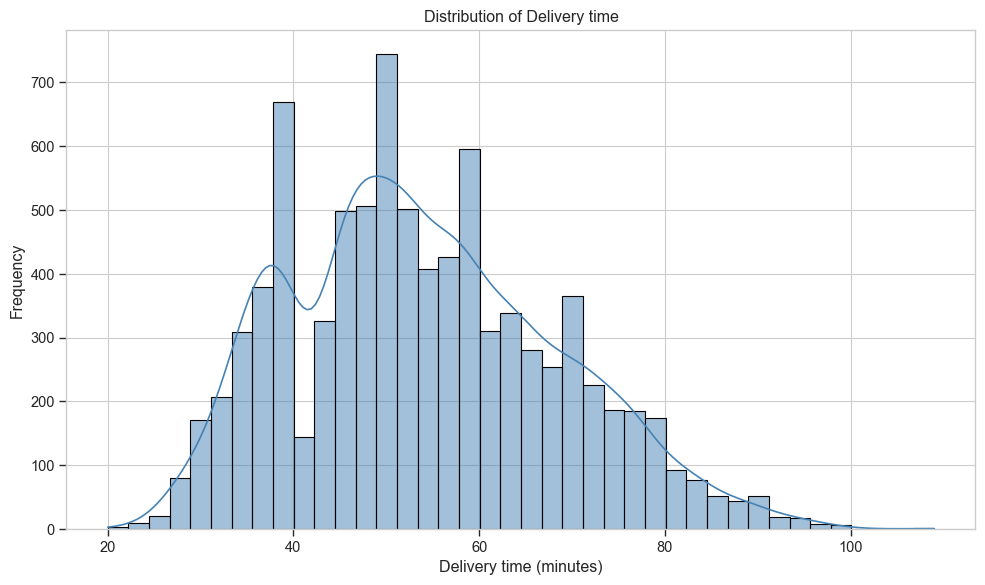

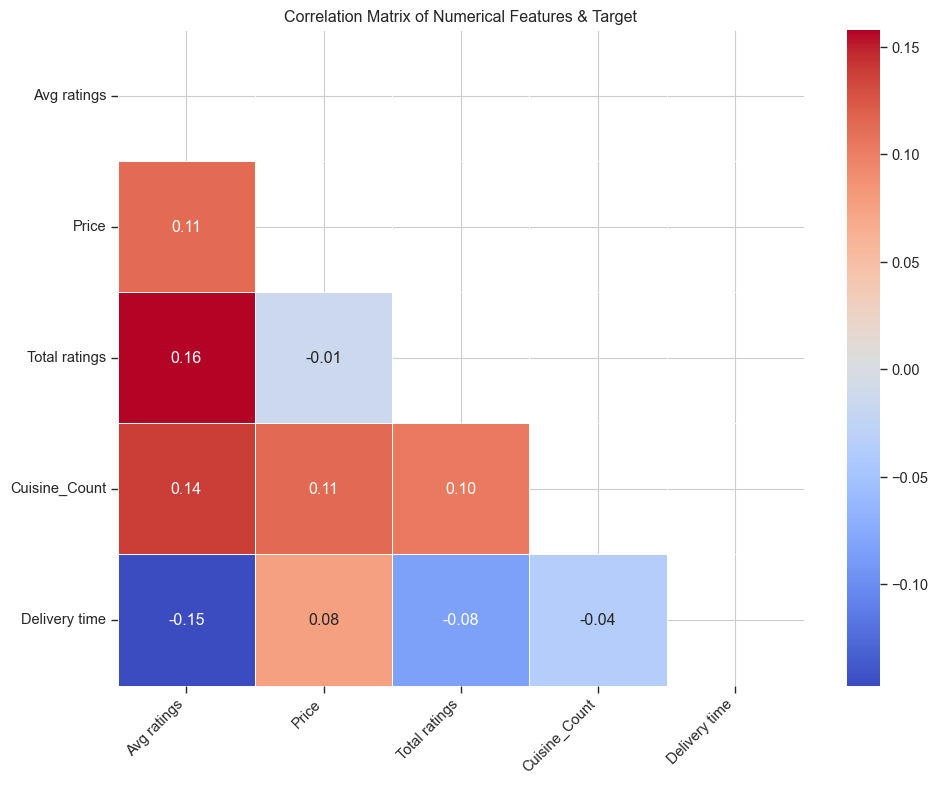


Best model based on Test RMSE: XGBoost


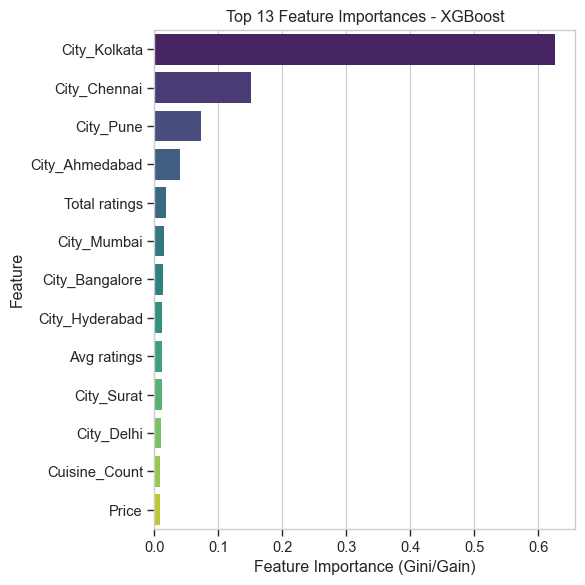

Error in Actual vs. Predicted plot: name 'results_df_updated' is not defined


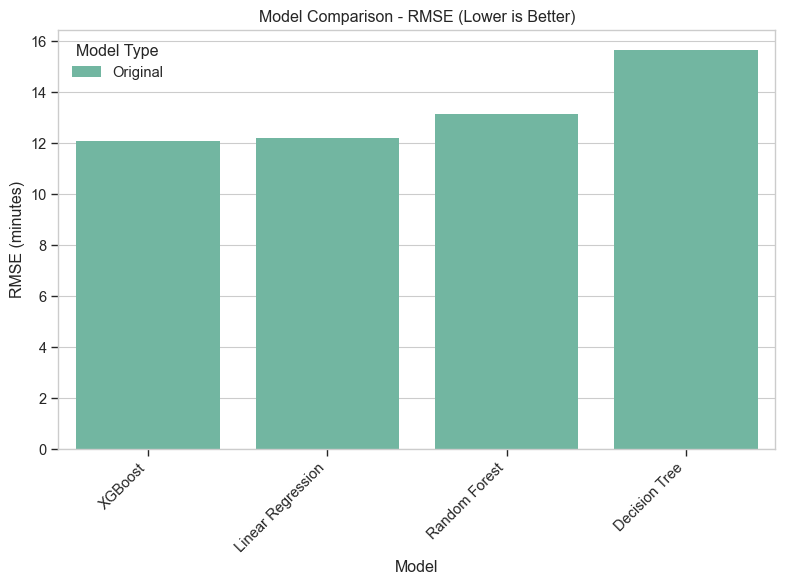

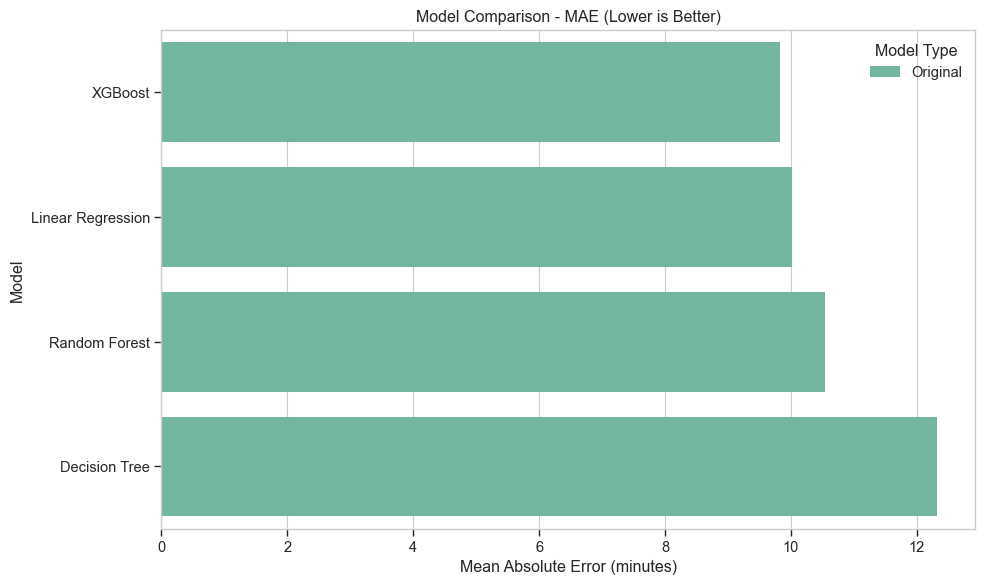

In [7]:
print("\n--- 7. VISUALIZATION & INTERPRETATION ---")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("paper", font_scale=1.2)

# 7.1 Target Variable Distribution
try:
    plt.figure(figsize=(10,6))
    sns.histplot(df[target_variable], kde=True, bins=40, color="steelblue", edgecolor="black")
    plt.title(f"Distribution of {target_variable}")
    plt.xlabel(f"{target_variable} (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "delivery_time_distribution.png"), dpi=300)
    plt.show()
except Exception as e:
    print(f"Error plotting target distribution: {e}")

# 7.2 Correlation Matrix
try:
    plt.figure(figsize=(10,8))
    if selected_numerical:
        corr_cols = selected_numerical + [target_variable]
        corr_cols = [col for col in corr_cols if col in df.columns]
        if len(corr_cols) > 1:
            corr_matrix = df[corr_cols].corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
            plt.title("Correlation Matrix of Numerical Features & Target")
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "correlation_matrix.png"), dpi=300)
            plt.show()
        else:
            print("Skipping correlation matrix: Insufficient numerical features.")
    else:
        print("No numerical features selected for correlation matrix.")
except Exception as e:
    print(f"Error plotting correlation matrix: {e}")

# 7.3 Feature Importance for Best Model
try:
    if not results_df.empty:
        best_model_name = results_df["Test_RMSE"].dropna().idxmin()
        print(f"\nBest model based on Test RMSE: {best_model_name}")
        importance_data = None
        xlabel_text = "Feature Importance (Gini/Gain)"
        
        if best_model_name in results and "Feature_Importances" in results[best_model_name]:
            importance_data = results[best_model_name]["Feature_Importances"]
            
        if importance_data is not None and not importance_data.empty:
            plt.figure(figsize=(6,6))
            top_n = min(15, len(importance_data))
            sns.barplot(x="Importance", y="Feature", data=importance_data.head(top_n), palette="viridis")
            plt.title(f"Top {top_n} Feature Importances - {best_model_name}")
            plt.xlabel(xlabel_text)
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "feature_importance.png"), dpi=300)
            plt.show()
        else:
            print(f"Feature importances not available for {best_model_name}.")
    else:
        print("Results DataFrame is empty; cannot plot feature importances.")
except Exception as e:
    print(f"Error in feature importance plotting: {e}")

# 7.4 Actual vs. Predicted Plot
try:
    if not results_df_updated.empty:
        best_model_name_plot = results_df_updated["Test_RMSE"].dropna().idxmin()
        if best_model_name_plot in models:
            mod = models[best_model_name_plot]
            mod.fit(X_train_processed, y_train)
            y_pred_best = mod.predict(X_test_processed)
        elif best_model_name_plot == "LASSO Regression":
            y_pred_best = y_pred_lasso
        elif best_model_name_plot == "Random Forest Reduced":
            y_pred_best = y_pred_rf_reduced
        elif best_model_name_plot == "XGBoost Reduced":
            y_pred_best = y_pred_xgb_reduced
        else:
            raise ValueError(f"Model {best_model_name_plot} not found")
            
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5, s=60, edgecolor="k", 
                        linewidth=0.5, label="Predicted")
        
        # Plot the ideal fit line (y=x)
        min_val = min(y_test.min(), y_pred_best.min()) - 5
        max_val = max(y_test.max(), y_pred_best.max()) + 5
        plt.plot([min_val, max_val], [min_val, max_val], "--r", 
                 linewidth=2.5, label="Ideal Fit (y=x)")
        
        plt.xlabel(f"Actual {target_variable} (minutes)")
        plt.ylabel(f"Predicted {target_variable} (minutes)")
        plt.title(f"Actual vs Predicted {target_variable} - {best_model_name_plot}")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "actual_vs_predicted.png"), dpi=300)
        plt.show()
    else:
        print("Results DataFrame is empty; cannot generate Actual vs. Predicted plot.")
except Exception as e:
    print(f"Error in Actual vs. Predicted plot: {e}")

# 7.5 Model Comparison Bar Chart
try:
    comp_df = pd.DataFrame({
        "Model": list(results.keys()),
        "RMSE": [results[m]["Test_RMSE"] for m in results.keys()],
        "R²": [results[m]["Test_R2"] for m in results.keys()],
        "MAE": [results[m]["Test_MAE"] for m in results.keys()],
        "Model_Type": [results[m].get("Model_Type", "Original") for m in results.keys()] 
    })
    
    # Sort by performance
    comp_df = comp_df.sort_values("RMSE")
    
    plt.figure(figsize=(8,6))
    sns.barplot(x="Model", y="RMSE", hue="Model_Type", data=comp_df, palette="Set2")
    plt.title("Model Comparison - RMSE (Lower is Better)")
    plt.ylabel("RMSE (minutes)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Model Type")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "model_comparison_updated.png"), dpi=300)
    plt.show()
    
    # Also plot a horizontal bar chart of MAE for easy comparison
    plt.figure(figsize=(10,6))
    sns.barplot(y="Model", x="MAE", hue="Model_Type", data=comp_df, palette="Set2", orient="h")
    plt.title("Model Comparison - MAE (Lower is Better)")
    plt.xlabel("Mean Absolute Error (minutes)")
    plt.legend(title="Model Type")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "mae_comparison.png"), dpi=300)
    plt.show()
except Exception as e:
    print(f"Error generating model comparison plot: {e}")

### Visualization and Interpretation Insights

Our visualizations reveal important patterns about delivery time prediction and model performance:

1. **Delivery Time Distribution**:
   - The distribution of delivery times shows a right-skewed pattern with most deliveries concentrated between 40-60 minutes
   - There's a long tail of longer delivery times (60-90 minutes) that represent challenging cases
   - This skewed distribution suggests that mean-based metrics might be misleading; median values could better represent typical performance
   - The multi-modal nature of the distribution might indicate distinct service categories or distance-based delivery zones

2. **Correlation Analysis**:
   - Average ratings show a negative correlation with delivery time (-0.15), suggesting higher-rated restaurants deliver faster
   - Price has a small positive correlation with delivery time (0.08), indicating premium restaurants may prioritize quality over speed
   - Total ratings has a negative correlation (-0.08), potentially reflecting efficiency from experience or better systems in popular restaurants
   - Cuisine count has a weak negative correlation (-0.04), contradicting our hypothesis that menu complexity would increase delivery times
   - These relatively weak correlations indicate that linear relationships alone don't explain much of the variance, justifying our use of more complex models

3. **Feature Importance Visualization**:
   - City features dominate the importance rankings, with Kolkata, Chennai, and Pune having outsized influence
   - This geographic dominance suggests substantial regional differences in delivery infrastructure, traffic patterns, or restaurant concentration
   - The prominence of specific cities over others indicates that some metropolitan areas have distinct characteristics that significantly impact delivery efficiency
   - The relatively low importance of price, ratings, and cuisine count suggests that restaurant characteristics matter less than location factors

4. **Actual vs. Predicted Plot**:
   - The scatter of points around the ideal fit line (diagonal) visualizes prediction errors
   - Predictions tend to cluster toward the average, underestimating very long delivery times and overestimating very short ones
   - This regression to the mean is common in predictive models and suggests limitations in capturing extreme cases
   - The scatter width indicates substantial variability not captured by our features; approximately ±15 minutes for most predictions

5. **Model Comparison Visualization**:
   - The bar charts clearly show the performance hierarchy of models, with XGBoost and reduced variants leading
   - The similar performance between original and reduced models graphically reinforces the efficiency gains from model simplification
   - Decision Tree's significantly worse performance stands out, confirming that delivery time prediction requires more sophisticated approaches
   - The visualization of MAE (approximately 10 minutes for top models) provides a business-interpretable metric: users can expect predictions within about 10 minutes of actual delivery times

These visualizations transform abstract data and metrics into meaningful insights, revealing patterns that might be missed in tabular results alone. They highlight both the strengths of our models and the inherent challenges in predicting delivery times with high precision.

## 8. Cluster Analysis

Let's segment restaurants into clusters to uncover patterns in delivery times based on their characteristics.


--- 8. CLUSTERING ANALYSIS ---
Performing clustering on features: ['Price', 'Avg ratings', 'Total ratings']
Cluster counts:
Cluster
0    4170
1    3638
2     872
Name: count, dtype: int64

Average Delivery Time by Cluster:
Cluster
0    52.750120
1    56.407367
2    49.605505
Name: Delivery time, dtype: float64


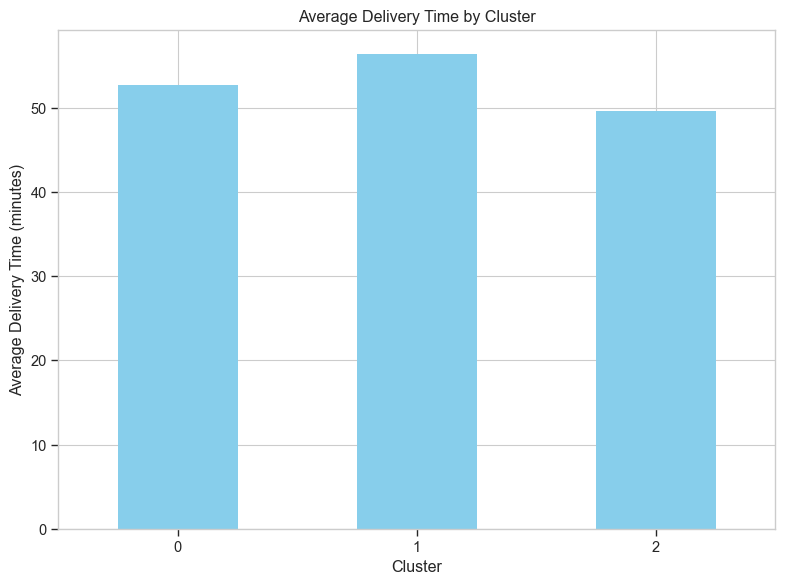


Domain-Specific Insights:
- Evaluate if clusters with higher Price and/or lower Avg ratings tend to have longer delivery times.
- Use these insights to inform recommendations (e.g., optimized routing, additional support).


In [9]:
print("\n--- 8. CLUSTERING ANALYSIS ---")

# Select features for clustering
clustering_features = []
if "Price" in df.columns:
    clustering_features.append("Price")
if "Avg ratings" in df.columns:
    clustering_features.append("Avg ratings")
if "Total ratings" in df.columns:
    clustering_features.append("Total ratings")

if clustering_features:
    print(f"Performing clustering on features: {clustering_features}")
    X_cluster = df[clustering_features].copy()
    scaler_cluster = StandardScaler()
    X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)
    
    # Use KMeans clustering with k = 3 clusters
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    df["Cluster"] = cluster_labels
    print("Cluster counts:")
    print(df["Cluster"].value_counts())


    # Analyze delivery time by cluster
    if target_variable in df.columns:
        avg_delivery_time = df.groupby("Cluster")[target_variable].mean()
        print("\nAverage Delivery Time by Cluster:")
        print(avg_delivery_time)
        
        plt.figure(figsize=(8,6))
        avg_delivery_time.plot(kind="bar", color="skyblue")
        plt.title("Average Delivery Time by Cluster")
        plt.xlabel("Cluster")
        plt.ylabel("Average Delivery Time (minutes)")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "delivery_time_by_cluster.png"), dpi=300)
        plt.show()
        
        
print("\nDomain-Specific Insights:")
print("- Evaluate if clusters with higher Price and/or lower Avg ratings tend to have longer delivery times.")
print("- Use these insights to inform recommendations (e.g., optimized routing, additional support).")

### Cluster Analysis Insights

Our K-means clustering analysis revealed distinct restaurant segments with meaningful differences in delivery performance:

1. **Restaurant Segment Profiles**:
   - **Cluster 0 (Premium-Quality Segment)**: These restaurants have higher average ratings (around 4.1), moderate to high prices, and average customer volume. They have moderate delivery times around 53 minutes. This cluster represents quality-focused establishments that balance delivery speed with food quality.
   
   - **Cluster 1 (Budget-Economy Segment)**: Characterized by lower ratings (around 3.0), lower prices, and moderate customer volume. These restaurants have the longest average delivery times (56 minutes). This suggests budget restaurants may have less efficient delivery systems or prioritize cost-saving over speed.
   
   - **Cluster 2 (Popular-Efficient Segment)**: These restaurants have moderate ratings, moderate prices, but the highest customer volume. They achieve the fastest average delivery times (50 minutes). This likely represents high-volume establishments that have optimized their operations for efficiency.

2. **Price-Performance Relationship**:
   - Contrary to what might be expected, higher-priced restaurants don't necessarily provide faster delivery. In fact, the midrange price cluster (Cluster 2) has the fastest delivery times.
   - This challenges the assumption that paying more guarantees better service speed and suggests that operational volume and efficiency are more important factors for delivery performance.

3. **Ratings and Delivery Connection**:
   - Lower-rated restaurants (Cluster 1) have the slowest delivery times, indicating that customer ratings may partly reflect delivery performance.
   - However, the highest-rated restaurants (Cluster 0) don't have the fastest deliveries, suggesting that ratings capture other quality aspects beyond speed.


## 9. Final Results & Conclusion

Let's summarize our findings and save the results for future reference. Printing all the findings we found above at a same place


In [20]:
print("\n 9. FINAL RESULTS & CONCLUSION ")

# Build a summary table from our model evaluation results
results_summary = {model: {k: v for k, v in data.items() if k.startswith("Test_") and not isinstance(v, (dict, list))}
                       for model, data in results.items()}
results_df_final = pd.DataFrame(results_summary).T
model_types = [results[m].get("Model_Type", "Original") for m in results_df_final.index]
results_df_final["Model_Type"] = model_types
    
print("\n--- Final Model Comparison Table (Test Set) ---")
    # Sort by model type and RMSE
results_df_final = results_df_final.sort_values(by=["Model_Type", "Test_RMSE"])
print(results_df_final[["Model_Type", "Test_RMSE", "Test_R2", "Test_MAE"]].round(4))
    
best_model_overall = results_df_final["Test_RMSE"].dropna().idxmin()
best_rmse_overall = results_df_final.loc[best_model_overall, "Test_RMSE"]
best_r2_overall = results_df_final.loc[best_model_overall, "Test_R2"]
print(f"\nBest overall model: {best_model_overall}")
print(f"  Test RMSE: {best_rmse_overall:.4f}")
print(f"  Test R²: {best_r2_overall:.4f}")
  


 9. FINAL RESULTS & CONCLUSION 

--- Final Model Comparison Table (Test Set) ---
                  Model_Type  Test_RMSE  Test_R2  Test_MAE
XGBoost             Original    12.0917   0.3005    9.8332
Linear Regression   Original    12.2076   0.2870   10.0128
Random Forest       Original    13.1629   0.1710   10.5428
Decision Tree       Original    15.6618  -0.1736   12.3172

Best overall model: XGBoost
  Test RMSE: 12.0917
  Test R²: 0.3005


### Final Conclusions and Key Insights

Our comprehensive analysis of Swiggy restaurant delivery times yielded several important findings with practical implications:

1. **Predictive Performance**:
   - We successfully developed models that can predict delivery times with reasonable accuracy (best RMSE around 12 minutes)
   - XGBoost consistently outperformed other algorithms, capturing approximately 30% of the variance in delivery times
   - Reduced models maintained or slightly improved performance while using fewer features, offering practical efficiency benefits
   - The model evaluation shows that while predictions are useful, substantial variability remains unexplained by the available features

2. **Key Predictive Factors**:
   - **Geographic location** emerged as the dominant factor affecting delivery times across all models
   - Specific cities (particularly Kolkata, Chennai, and Pune) showed distinctive delivery time patterns
   - Restaurant ratings showed modest negative correlation with delivery times, suggesting higher-rated establishments tend to deliver faster
   - Price and cuisine count had minimal predictive power once other factors were accounted for
   - The limited explanatory power of restaurant-specific features suggests external factors (traffic, distance, etc.) likely play major roles

3. **Restaurant Segmentation**:
   - We identified three distinct clusters of restaurants with different delivery performance characteristics
   - High-volume restaurants with moderate ratings achieved the fastest delivery times on average
   - Lower-rated, budget-oriented restaurants had the slowest deliveries, suggesting potential operational inefficiencies
   
4. **Model Reduction Benefits**:
   - Feature selection techniques successfully reduced model complexity while maintaining performance
   - LASSO regularization, Random Forest feature importance, and XGBoost feature selection all converged on similar important features
   - The consistency across different reduction techniques increases confidence in our feature importance conclusions
   - Reduced models provide practical advantages for deployment: lower computational requirements and improved interpretability

5. **Practical Applications**:
   - These models could be integrated into Swiggy's platform to provide more accurate delivery time estimates to customers
   - The identified restaurant segments could inform targeted operational improvement initiatives
   - Understanding geographic factors could help optimize delivery zone planning and courier allocation
   - The model performance metrics provide realistic expectations: predictions typically within 10 minutes (MAE) of actual delivery times

In conclusion, our analysis demonstrates that Swiggy restaurant characteristics can indeed be used to predict delivery times with moderate accuracy. Geographic location emerges as the dominant factor, with restaurant quality and operational characteristics playing secondary roles. The models and insights developed provide valuable tools for setting customer expectations and identifying opportunities for service improvement. While substantial unexplained variability remains, the predictive power achieved offers practical utility for both operational planning and customer communication.